In [333]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt

%matplotlib inline

In [334]:
from typing import Final

# Settings cell
IS_CONCAT_TRAINING_EXTRA = False
RANDON_STATE: Final[int] = 42

LINEAR_REGRESSION_MODEL: Final[str] = 'linear_regression'
XGBOOST_MODEL: Final[str] = 'xgboost'

SELECTED_MODEL = LINEAR_REGRESSION_MODEL

AVAILABLE_MODELS = {
    LINEAR_REGRESSION_MODEL: LinearRegression(),
    XGBOOST_MODEL: XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=RANDON_STATE)
}

In [335]:
train_raw_df = pd.read_csv('data/train.csv')
training_extra_raw_df = pd.read_csv('data/training_extra.csv')

raw_df = train_raw_df
# Combine them
if IS_CONCAT_TRAINING_EXTRA:
  raw_df = pd.concat([train_raw_df, training_extra_raw_df], ignore_index=True)



In [336]:
ProfileReport(raw_df)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


In [337]:
raw_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


### EDA analysis

**Variable types**

* Numeric	4
* Categorical	5
* Boolean	2



### Data preprocessing

In [338]:
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(columns=['id', 'Price']), raw_df['Price'], test_size=0.2, random_state=RANDON_STATE)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 254099 to 121958
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 232255 non-null  object 
 1   Material              233326 non-null  object 
 2   Size                  234720 non-null  object 
 3   Compartments          240000 non-null  float64
 4   Laptop Compartment    234075 non-null  object 
 5   Waterproof            234286 non-null  object 
 6   Style                 233605 non-null  object 
 7   Color                 232008 non-null  object 
 8   Weight Capacity (kg)  239890 non-null  float64
dtypes: float64(2), object(7)
memory usage: 18.3+ MB


In [339]:
input_cols = list(X_train.columns)
target_col = 'Price'

train_inputs, train_targets = X_train[input_cols], y_train
val_inputs, val_targets = X_test[input_cols], y_test

print(f'{input_cols=}')
print(f'{target_col=}')

input_cols=['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']
target_col='Price'


In [340]:
train_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240000 entries, 254099 to 121958
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 232255 non-null  object 
 1   Material              233326 non-null  object 
 2   Size                  234720 non-null  object 
 3   Compartments          240000 non-null  float64
 4   Laptop Compartment    234075 non-null  object 
 5   Waterproof            234286 non-null  object 
 6   Style                 233605 non-null  object 
 7   Color                 232008 non-null  object 
 8   Weight Capacity (kg)  239890 non-null  float64
dtypes: float64(2), object(7)
memory usage: 18.3+ MB


In [341]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
binary_cols = ['Waterproof', 'Laptop Compartment']
categorical_cols = ['Brand', 'Material', 'Style', 'Color']
size_col: Final[str] = 'Size'

print(f'{numeric_cols=}')
print(f'{binary_cols=}')
print(f'{categorical_cols=}')
print(f'{size_col=}')

numeric_cols=['Compartments', 'Weight Capacity (kg)']
binary_cols=['Waterproof', 'Laptop Compartment']
categorical_cols=['Brand', 'Material', 'Style', 'Color']
size_col='Size'


In [342]:
# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

# Pipeline for boolean features
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(dtype=int))
])

# Pipeline for categorical features except 'Size'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Works well for categorical features with low cardinality.
])

# Pipeline specifically for 'Size' feature
size_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ordinal', OrdinalEncoder(categories=[['Small', 'Medium', 'Large']],
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

#### Additional notes on transformers
•	High Cardinality Problem:
If any categorical feature (like “Brand” or “Color”) has a large number of unique values, OneHotEncoder will create too many features, making the model inefficient.

### Train the model

In [343]:
# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('bool', binary_transformer, binary_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('size', size_transformer, [size_col])
    ])

model = AVAILABLE_MODELS[SELECTED_MODEL]

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Compartments',
                                                   'Weight Capacity (kg)']),
                                                 ('bool',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(dtype=<class 'int'>))]),
                                                  ['Waterproof',
                                                   'Laptop Compartment']),
                                                 ('cat',...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Brand', 'Material', 'Style',
                                                   'Color']),
                                                 ('size',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Small',
                                                                                               'Medium',
                                                                                               'Large']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Size'])])),
                ('classifier', LinearRegression())])

In [344]:
# Predict on validation data
y_train_pred = model_pipeline.predict(train_inputs)
y_val_pred = model_pipeline.predict(val_inputs)

In [345]:
# Compute RMSE on training and validation data
train_rmse = root_mean_squared_error(y_train, y_train_pred)
val_rmse = root_mean_squared_error(y_test, y_val_pred)
r2 = r2_score(y_test, y_val_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f'Validation R² Score: {r2:.4f}')

Train RMSE: 39.0417
Validation RMSE: 38.9204
Validation R² Score: 0.0012


### Observations
* R2 score is very low which shows us that the model is not able to explain the variance in the data.

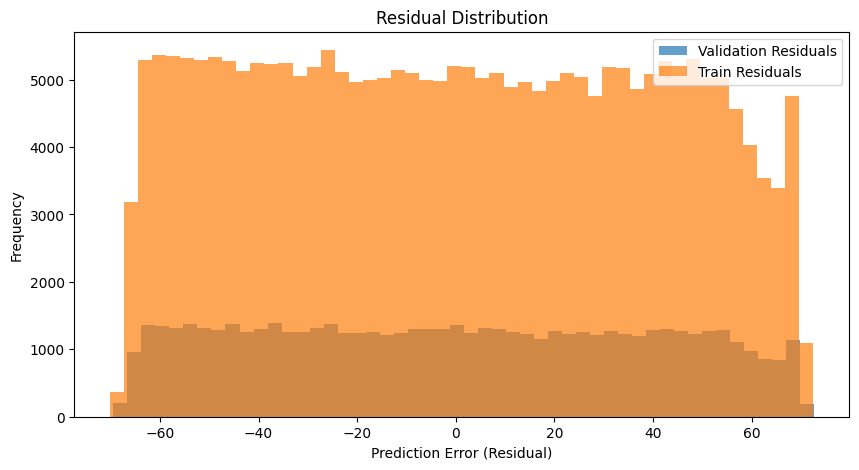

In [346]:
# Calculate residuals
train_residuals = y_train - y_train_pred
val_residuals = y_test - y_val_pred

# Plot residuals
plt.figure(figsize=(10, 5))
plt.hist(val_residuals, bins=50, alpha=0.7, label="Validation Residuals")
plt.hist(train_residuals, bins=50, alpha=0.7, label="Train Residuals")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Residual Distribution")
plt.show()

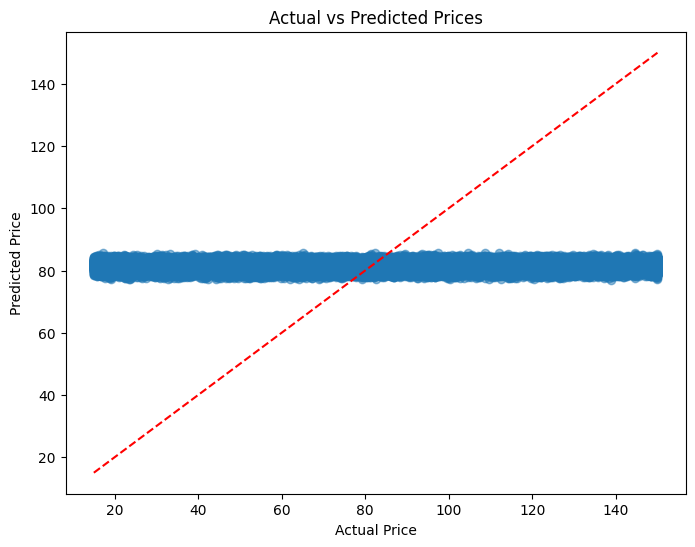

In [347]:
# Scatter Plot of Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_val_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")
plt.show()

In [348]:
if SELECTED_MODEL == LINEAR_REGRESSION_MODEL:
  feature_names = (
      numeric_cols +
      binary_cols +
      list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)) +
      [size_col]
  )

  coefficients = model_pipeline.named_steps['classifier'].coef_

  coefficients_df = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coefficients,
      'Absolute_Coefficient': np.abs(coefficients)
  }).sort_values(by='Absolute_Coefficient', ascending=False)

  print(coefficients_df.head(10))  # Show top 10 most important features
elif SELECTED_MODEL == XGBOOST_MODEL:
  feature_importance = model_pipeline.named_steps['classifier'].feature_importances_
  feature_names = (
      numeric_cols +
      binary_cols +
      list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)) +
      [size_col]
  )

  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

  print(feature_importance_df.head(15))  # Show top 15 important features

                 Feature  Coefficient  Absolute_Coefficient
1   Weight Capacity (kg)     2.454747              2.454747
11      Material_Leather    -1.022479              1.022479
19           Color_Black    -0.972349              0.972349
22           Color_Green     0.930572              0.930572
4           Brand_Adidas    -0.773298              0.773298
10       Material_Canvas     0.690499              0.690499
18         Style_missing     0.610728              0.610728
8     Brand_Under Armour     0.562020              0.562020
13    Material_Polyester     0.524045              0.524045
20            Color_Blue     0.523811              0.523811


### Prepare sample submission

TODO: migrate to `utils` module

In [ ]:
test_raw_df = pd.read_csv('data/test.csv')

# Predict on test data
test_predictions = model_pipeline.predict(test_raw_df)

In [ ]:
# Read sample submission
sample_submission = pd.read_csv('data/sample_submission.csv')

sample_submission.head(n=5)

In [ ]:
# Fill 'Exited' column with predictions
sample_submission['Price'] = test_predictions

# Save the submission
if SELECTED_MODEL == LINEAR_REGRESSION_MODEL:
  file_to_save = 'data/submission_linear_regression.csv'
elif SELECTED_MODEL == XGBOOST_MODEL:
  file_to_save = 'data/submission_xgboost.csv'
sample_submission.to_csv(file_to_save, index=False)
sample_submission.head(n=5)